In [8]:
import os
import time
import datetime

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import numpy as np 
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from chainconsumer import Chain, ChainConsumer, Truth
from tensorflow_probability.substrates.jax.distributions import Distribution

from configs import (
    cumulants_config, get_results_dir, get_posteriors_dir, 
    get_cumulants_sbi_args, get_ndes_from_config
)
from cumulants import (
    CumulantsDataset, Dataset, get_data, get_prior, 
    get_compression_fn, get_datavector, get_linearised_data
)

from sbiax.utils import make_df, marker
from sbiax.ndes import Scaler, Ensemble, CNF, MAF 
from sbiax.train import train_ensemble
from sbiax.inference import nuts_sample

from affine import affine_sample
from utils import plot_moments, plot_latin_moments, plot_summaries, plot_fisher_summaries

In [9]:
t0 = time.time()

Finvs = []
for order_idx in [[0], [0, 1], [0, 1, 2]]:

    args = ConfigDict()
    args.seed                = 0
    args.redshift            = 0.
    args.sbi_type            = "nle"
    args.linearised          = True
    args.reduced_cumulants   = True
    args.compression         = "linear"
    args.order_idx           = order_idx
    args.pre_train           = True and (not args.linearised)
    args.n_linear_sims       = 10_000

    config = cumulants_config(**args)

    args.verbose             = False
    args.use_tqdm            = True

    key = jr.key(config.seed)

    ( 
        model_key, train_key, key_prior, 
        key_datavector, key_state, key_sample
    ) = jr.split(key, 6)

    results_dir = get_results_dir(config, args)

    posteriors_dir = get_posteriors_dir(config)

    cumulants_dataset = CumulantsDataset(config)

    print("DATA:", ["{:.3E} {:.3E}".format(_.min(), _.max()) for _ in (cumulants_dataset.data.fiducial_data, cumulants_dataset.data.data)])
    print("DATA:", [_.shape for _ in (cumulants_dataset.data.fiducial_data, cumulants_dataset.data.data)])

    # Compress simulations
    X = jax.vmap(cumulants_dataset.compression_fn, in_axes=(0, None))(cumulants_dataset.data.fiducial_data, cumulants_dataset.data.alpha)

    Finvs.append(cumulants_dataset.data.Finv)

RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/sbiax/results/reduced_cumulants/nle/linearised/linear/z=0.0_m=0/0/
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/sbiax/results/posteriors/reduced_cumulants/nle/linearised/linear/z=0.0_m=0/0/
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 7) (10000, 5)
Using flat prior
DATA: ['5.060E-02 1.950E+00', '-3.875E-02 3.173E+00']
DATA: [(15000, 7), (10000, 7)]
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/sbiax/results/reduced_cumulants/nle/linearised/linear/z=0.0_m=01/0/
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/sbiax/results/posteriors/reduced_cumulants/nle/linearised/linear/z=0.0_m=01/0/
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 14) (10000, 5)
Using flat prior
DATA: ['5.060E-02 5.742E+00', '-3.869E+01 3.773E+01']
DATA: [(15000, 14), (10000, 14)]
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/sbiax/results/reduced_cumulants/nle/linearised/linear/z=0.0_m=012/0/
RESU

In [ ]:
# Compress simulations
# compression_fn = get_compression_fn(config, dataset, results_dir=results_dir)
# X = jax.vmap(compression_fn, in_axes=(0, None))(dataset.fiducial_data, dataset.alpha)

c = ChainConsumer()
for n, Finv in enumerate(Finvs):
    c.add_chain(
        Chain.from_covariance(
            cumulants_dataset.data.alpha,
            Finv,
            columns=cumulants_dataset.get_parameter_strings(),
            name=r"$F_{\Sigma^{-1}}$ " + str(n),
            color="k",
            linestyle=":",
            shade_alpha=0.
        )
    )
c.add_truth(
    Truth(
        location=dict(zip(cumulants_dataset.get_parameter_strings(), cumulants_dataset.data.alpha)), 
        name=r"$\pi^0$"
    )
)
fig = c.plotter.plot()
plt.show()

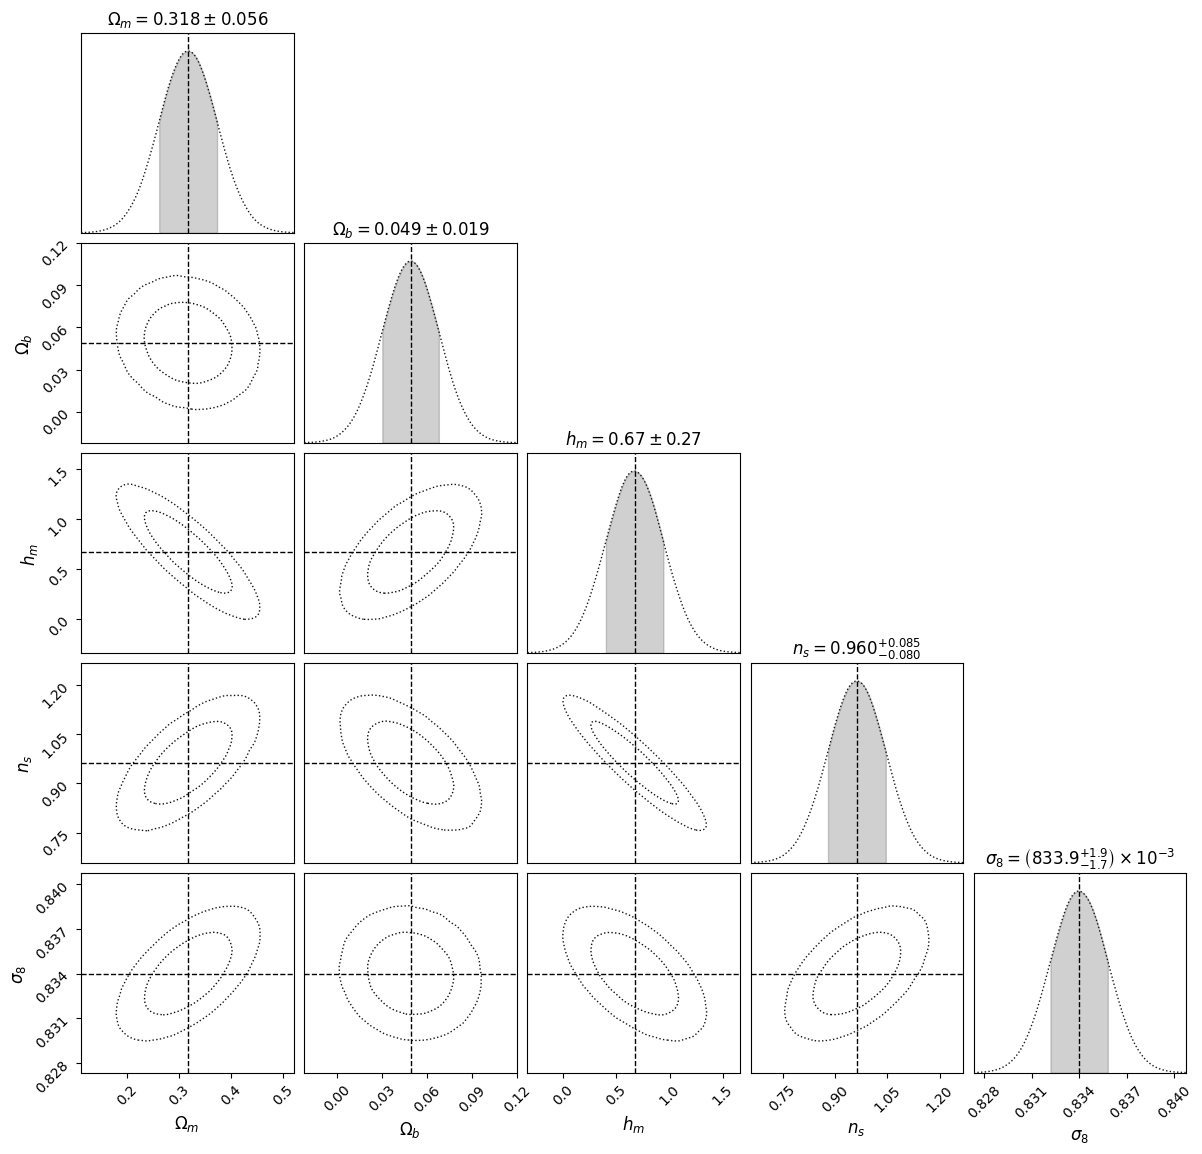

In [ ]:
# Compress simulations
# compression_fn = get_compression_fn(config, dataset, results_dir=results_dir)
# X = jax.vmap(compression_fn, in_axes=(0, None))(dataset.fiducial_data, dataset.alpha)

c = ChainConsumer()
for n, Finv in enumerate(Finvs[-1:]):
    c.add_chain(
        Chain.from_covariance(
            cumulants_dataset.data.alpha,
            Finv,
            columns=cumulants_dataset.get_parameter_strings(),
            name=r"$F_{\Sigma^{-1}}$ " + str(n),
            color="k",
            linestyle=":",
            shade_alpha=0.
        )
    )
c.add_truth(
    Truth(
        location=dict(zip(cumulants_dataset.get_parameter_strings(), cumulants_dataset.data.alpha)), 
        name=r"$\pi^0$"
    )
)
fig = c.plotter.plot()
plt.show()

In [ ]:
Finv = jnp.sum(jnp.stack(Finvs), axis=0)

c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        cumulants_dataset.data.alpha,
        Finv,
        columns=cumulants_dataset.get_parameter_strings(),
        name=r"$F_{\Sigma^{-1}}$ " + str(n),
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
c.add_truth(
    Truth(
        location=dict(zip(cumulants_dataset.get_parameter_strings(), cumulants_dataset.data.alpha)), 
        name=r"$\pi^0$"
    )
)
fig = c.plotter.plot()
plt.show()

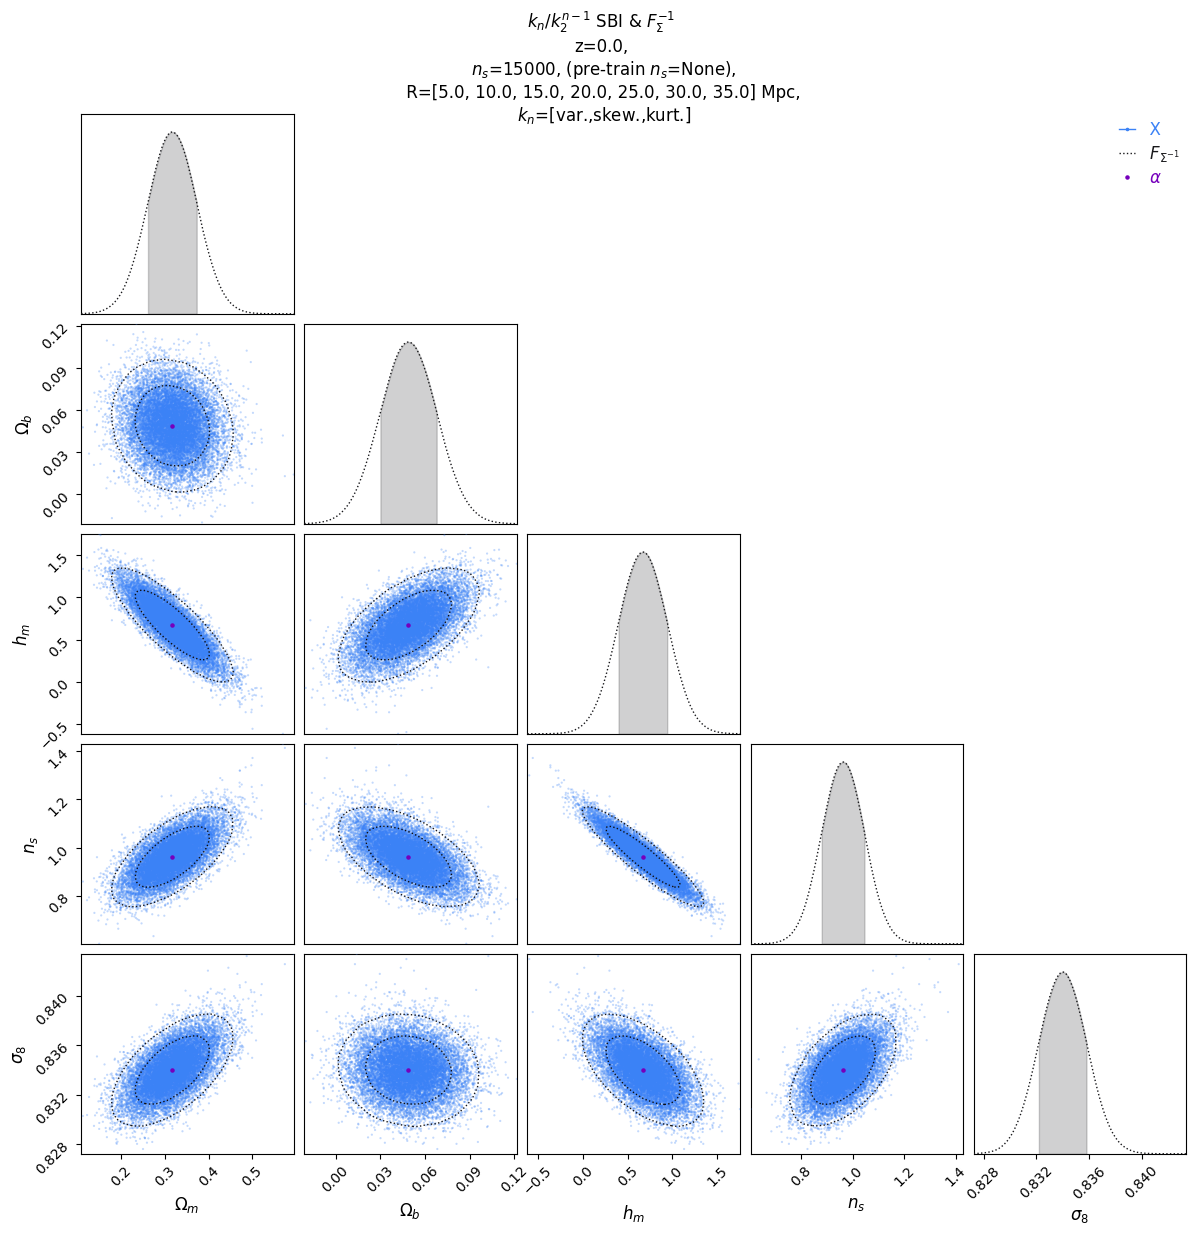

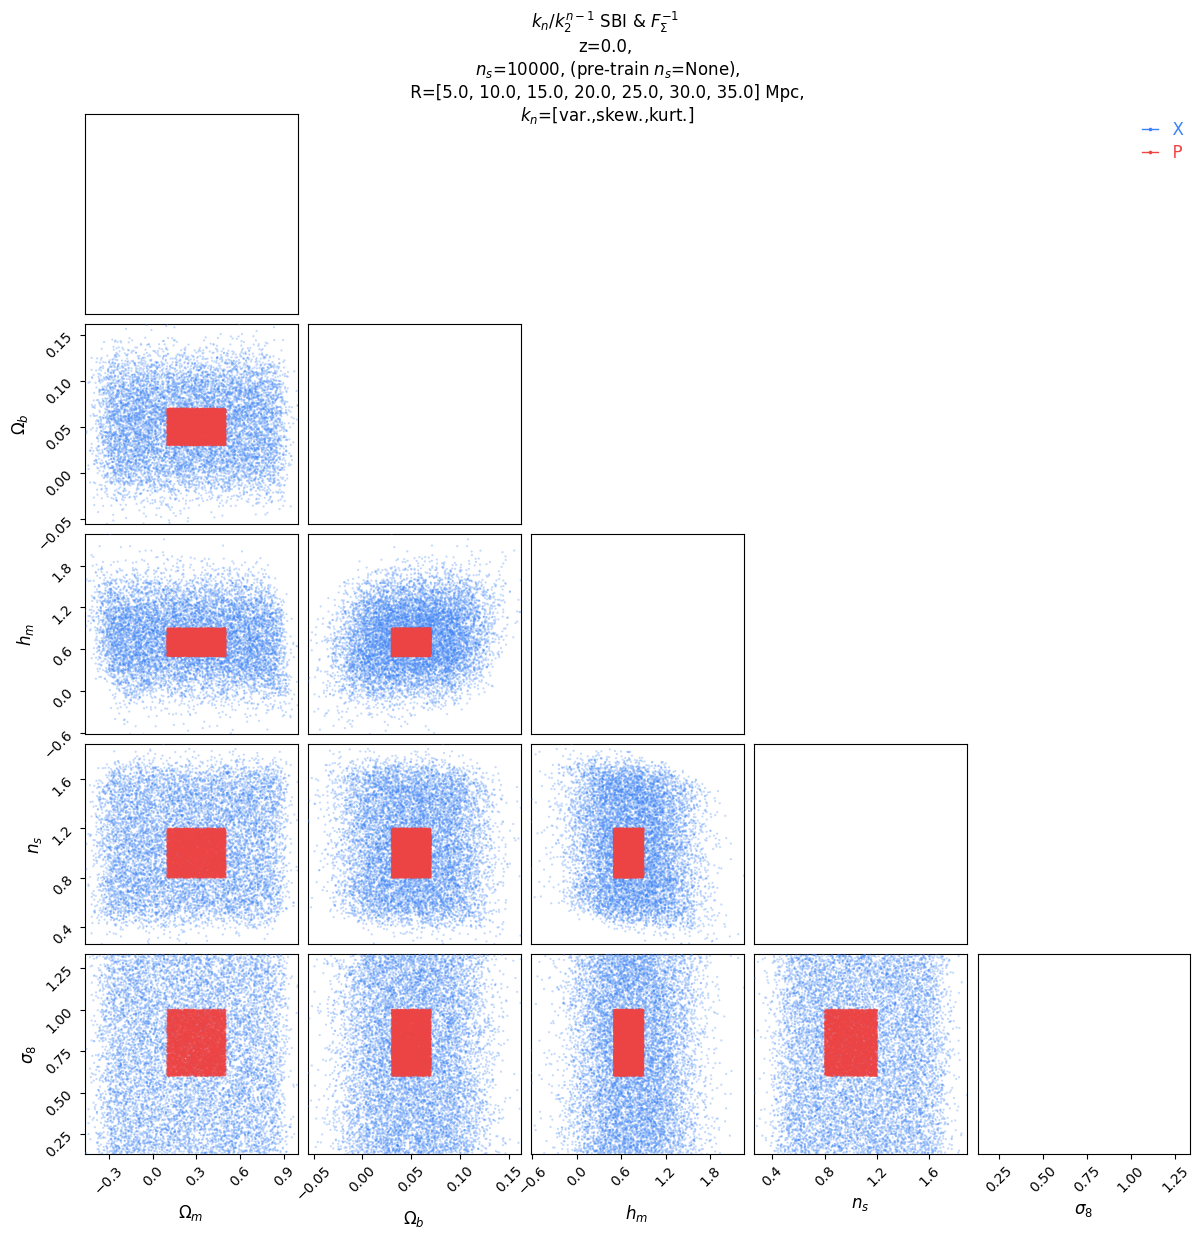

In [ ]:
args = ConfigDict()
args.seed                = 0
args.redshift            = 0.
args.sbi_type            = "nle"
args.linearised          = True 
args.reduced_cumulants   = False 
args.compression         = "linear"
args.order_idx           = [0, 1, 2]
args.pre_train           = True and (not args.linearised)
args.n_linear_sims       = 100_000

config = cumulants_config(**args)

dataset: Dataset = cumulants_dataset.data

mu = jnp.mean(dataset.fiducial_data, axis=0)
dmu = jnp.mean(dataset.derivatives, axis=0)

def mle(d, p):
    mu_p = mu + jnp.dot(dataset.alpha - p, dmu) 
    return p + jnp.linalg.multi_dot([dataset.Finv, dmu, dataset.Cinv, d - mu_p])

# Fiducial
X = jax.vmap(dataset.compression_fn, in_axes=(0, None))(dataset.fiducial_data, dataset.alpha)
# X = jax.vmap(mle, in_axes=(0, None))(dataset.fiducial_data, dataset.alpha)

c = ChainConsumer()
c.add_chain(
    Chain(
        samples=make_df(X, parameter_strings=dataset.parameter_strings), 
        name="X", 
        color="b", 
        plot_contour=False, 
        plot_cloud=True
    )
)
c.add_chain(
    Chain.from_covariance(
        dataset.alpha,
        dataset.Finv,
        columns=dataset.parameter_strings,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
# c.add_chain(
#     Chain(
#         samples=make_df(dataset.parameters, parameter_strings=dataset.parameter_strings), 
#         plot_contour=False, 
#         plot_cloud=True, 
#         name="P", 
#         color="r"
#     )
# )
c.add_marker(
    location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
    name=r"$\alpha$", 
    color="#7600bc"
)
fig = c.plotter.plot()
fig.suptitle(
    r"$k_n/k_2^{n-1}$ SBI & $F_{{\Sigma}}^{{-1}}$" + "\n" +
    "z={},\n $n_s$={}, (pre-train $n_s$={}),\n R={} Mpc,\n $k_n$={}".format(
            config.redshift, 
            len(X), 
            config.n_linear_sims if config.pre_train else None,
            "[{}]".format(", ".join(map(str, config.scales))),
            "[{}]".format(",".join(map(str, [["var.", "skew.", "kurt."][_] for _ in config.order_idx])))
        ),
    multialignment='center'
)
plt.show()

# Hypercube
# X = jax.vmap(mle)(dataset.data, dataset.parameters)
X = jax.vmap(dataset.compression_fn)(dataset.data, dataset.parameters)

c = ChainConsumer()
c.add_chain(
    Chain(
        samples=make_df(X, parameter_strings=dataset.parameter_strings), 
        name="X", 
        color="b", 
        plot_contour=False, 
        plot_cloud=True
    )
)
c.add_chain(
    Chain(
        samples=make_df(dataset.parameters, parameter_strings=dataset.parameter_strings), 
        plot_contour=False, 
        plot_cloud=True, 
        name="P", 
        color="r"
    )
)
fig = c.plotter.plot()
fig.suptitle(
    r"$k_n/k_2^{n-1}$ SBI & $F_{{\Sigma}}^{{-1}}$" + "\n" +
    "z={},\n $n_s$={}, (pre-train $n_s$={}),\n R={} Mpc,\n $k_n$={}".format(
            config.redshift, 
            len(X), 
            config.n_linear_sims if config.pre_train else None,
            "[{}]".format(", ".join(map(str, config.scales))),
            "[{}]".format(",".join(map(str, [["var.", "skew.", "kurt."][_] for _ in config.order_idx])))
        ),
    multialignment='center'
)
plt.show()

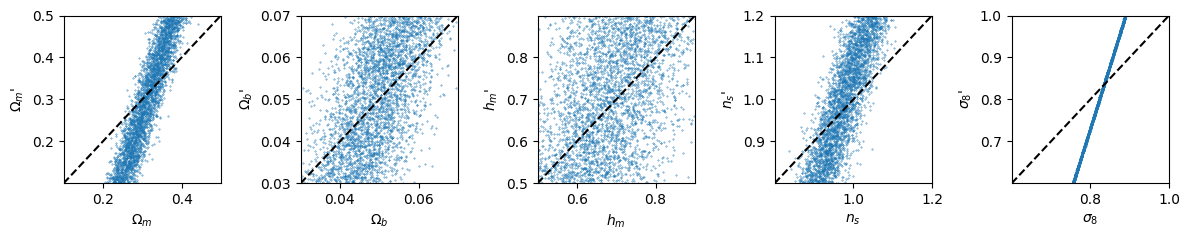

In [ ]:
fig, axs = plt.subplots(1, dataset.alpha.size, figsize=(2. + 2. * dataset.alpha.size, 2.5))
for p, ax in enumerate(axs):
    ax.scatter(dataset.parameters[:, p], X[:, p], s=0.1)
    ax.axline((0, 0), slope=1., color="k", linestyle="--")
    ax.set_xlim(dataset.lower[p], dataset.upper[p])
    ax.set_ylim(dataset.lower[p], dataset.upper[p])
    ax.set_xlabel(dataset.parameter_strings[p])
    ax.set_ylabel(dataset.parameter_strings[p] + "'")
plt.tight_layout()
plt.show()

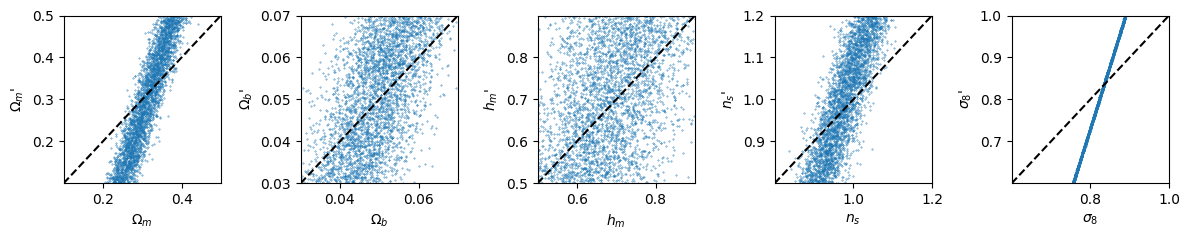

In [ ]:
mu = jnp.mean(dataset.fiducial_data, axis=0)
dmu = jnp.mean(dataset.derivatives, axis=0)

def compressor(d, p): 
    mu_p = mu + jnp.dot(p - dataset.alpha, dmu) 
    p_ = mle(
        d,
        pi=p,
        Finv=dataset.Finv, 
        mu=mu_p,            
        dmu=dmu, 
        precision=dataset.Cinv
    )
    return p_

# Hypercube
X = jax.vmap(mle)(dataset.data, dataset.parameters)

fig, axs = plt.subplots(1, dataset.alpha.size, figsize=(2. + 2. * dataset.alpha.size, 2.5))
for p, ax in enumerate(axs):
    ax.scatter(dataset.parameters[:, p], X[:, p], s=0.1)
    ax.axline((0, 0), slope=1., color="k", linestyle="--")
    ax.set_xlim(dataset.lower[p], dataset.upper[p])
    ax.set_ylim(dataset.lower[p], dataset.upper[p])
    ax.set_xlabel(dataset.parameter_strings[p])
    ax.set_ylabel(dataset.parameter_strings[p] + "'")
plt.tight_layout()
plt.show()